# Simulation-Based Inference for decision-making models

This tutorial is based on the SBI tutorial [SBI for decision-making models](https://sbi-dev.github.io/sbi/examples/01_decision_making_model/), an example how to use SBI with trial-based iid data as they typically occur when modeling perceptual decision making experiments.
To show the power of the approach, we will assume mixed data types (continuous reaction times and categorical choices) and varying
experimental conditions. Here, we show how `sbi` can be used to perform inference in such models with the `MNLE` method.

## Trial-based SBI with mixed data types

In some cases, models with trial-based data additionally return data with mixed data types, e.g., continous and discrete data. For example, most computational models of decision-making have continuous reaction times and discrete choices as output.

This can induce a problem when performing trial-based SBI that relies on learning a neural likelihood: It is challenging for most density estimators to handle both, continuous and discrete data at the same time.
However, there is a recent SBI method for solving this problem, it's called **Mixed Neural Likelihood Estimation** (MNLE). It works just like NLE, but with mixed data types. The trick is that it learns two separate density estimators, one for the discrete part of the data, and one for the continuous part, and combines the two to obtain the final neural likelihood. Crucially, the continuous density estimator is trained conditioned on the output of the discrete one, such that statistical dependencies between the discrete and continuous data (e.g., between choices and reaction times) are modeled as well. The interested reader is referred to the original paper available [here](https://elifesciences.org/articles/77220).

MNLE was recently added to `sbi` (see this [PR](https://github.com/mackelab/sbi/pull/638) and also [issue](https://github.com/mackelab/sbi/issues/845)) and follows the same API as `SNLE`.

In this tutorial we will show how to apply `MNLE` to mixed data, and how to deal with varying experimental conditions.

If you haven't installed `sbi` yet, run the cell below.

In [ ]:
!pip install sbi

## Toy problem for `MNLE`

To illustrate `MNLE` we set up a toy model that outputs mixed data. The model consists of the following:

- Sample reaction time (a positive continuous value) from `inverse Gamma`: $rt \sim \text{InverseGamma}(\alpha, \beta)$. Here we will assume that the shape parameter $\alpha$ is fixed at 2, the only free parameter is the scale parameter $\beta$.
- Sample binary choices from `Binomial` $c \sim \text{Binomial}(\rho)$, i.e. $c=1$ with probability $\rho$ and 0 with probability 1-$\rho$.

So this model has two free parameters $(\beta,\rho)$ and outputs two variables: a continuous and a binary value (hence the label 'mixed data').
For this generative model we can know the true likelihood such we can compare the posterior found using either the approximate likelihood (MNLE) or true likelihood.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize

import torch
from pyro.distributions import InverseGamma
from torch import Tensor
from torch.distributions import Beta, Binomial, Categorical, Gamma, Uniform

from sbi.analysis import pairplot
from sbi.inference import MNLE, MCMCPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.inference.potentials.likelihood_based_potential import (
    MixedLikelihoodBasedPotential,
)
from sbi.utils import MultipleIndependent, mcmc_transform
from sbi.utils.conditional_density_utils import ConditionedPotential
from sbi.utils.metrics import c2st
from sbi.utils.torchutils import atleast_2d


### Write down your simulation function.
This is the key part. We need to write a function that takes the parameters as arguments and returns the simulated data.
Important: this function needs to be written using `pytorch`. The parameters will be passed on as pytorch tensors, and the simulated data will be output as pytorn tensors as well (with one row for each trial).
If you recycle this tutorial to fit your own model, change this simulator.

In [2]:
# Toy simulator for mixed data
def mixed_simulator(theta: Tensor, concentration_scaling: float = 1.0):
    """Returns a sample from a mixed distribution given parameters theta.

    Args:
        theta: batch of parameters, shape (batch_size, 2) 
        concentration_scaling:
        scaling factor for the concentration parameter of the InverseGamma
        distribution, mimics an experimental condition. (see later)

    """
    # first column is beta parameter, second is rho
    beta, rho = theta[:, :1], theta[:, 1:]

    # simulate choices using binomial distribution
    choices = Binomial(probs=rho).sample()

    # simulate gamma using inverse gamma distribution
    alpha = concentration_scaling * torch.ones_like(beta)
    rts = InverseGamma(concentration=alpha, rate=beta).sample()

    # concatenate RTS and choices in tensor
    x = torch.cat((rts, choices), dim=1)
    return x

Ok, let's simulate 10 trials of this model with parameters $\beta=1$ and $\rho=.2$. First column represents RT, second column represents choices.

In [3]:
beta = 1
rho = .2
theta = torch.tensor((beta,rho)).repeat(10, 1)
mixed_simulator(theta)

tensor([[0.8952, 0.0000],
        [0.8581, 0.0000],
        [0.9046, 0.0000],
        [0.8426, 0.0000],
        [0.2039, 0.0000],
        [1.3825, 0.0000],
        [4.0559, 0.0000],
        [0.4493, 1.0000],
        [2.5658, 0.0000],
        [1.7859, 0.0000]])

Let's simulate the model for a larger dataset and observe the produce behavior. You can check there that the RT distributions for choice 0 and choice 1 are identical (up to a scaling factor), which reflects the fact that choices and RTs are generated from completely independent processes.

In [4]:
import ipywidgets as widgets       # interactive display
@widgets.interact(
    beta=widgets.FloatSlider(1.5, min=0.1, max=4.0), # default, min and max values for noise variance param
    rho=widgets.FloatSlider(0.5, min=0.0, max=1.0)) # defaul, min and max values for lapse parameter

def plot_RT_choice_dist(beta, rho):
    nTrial = 5000
    
    # simulate model
    x_example = mixed_simulator(torch.tensor((beta,rho)).repeat(nTrial, 1)).numpy()
    RTs = x_example[:,0]
    choices = x_example[:,1]

    # plot histograms
    RTcutoff=10 # exclude RTs above 10
    plt.hist(RTs[(choices==0) & (RTs<RTcutoff)], 50,color='b',label='choice = 0');
    plt.hist(RTs[(choices==1) & (RTs<RTcutoff)], 50,color='r',label='choice = 1');
    plt.legend();
    plt.show();

interactive(children=(FloatSlider(value=1.5, description='beta', max=4.0, min=0.1), FloatSlider(value=0.5, des…

### Define a prior over parameters
To run Bayesian inference over the parameters, we also need to define a prior over these parameters, specifying what we seem plausible values of these parameters (without even considering the actual data). 

As in often used, we take the priors of the two parameters $\rho$ and $\beta$ to be independent. We define a `Beta` prior over parameter $\rho$ (this is a standard prior for probability parameteers), and a `Gamma` prior over the $\beta$ parameter (this is a standard prior for positive continuous parameters):

$$p(\beta, \rho) = p(\beta) \; p(\rho) \text{(independent priors)}$$
$$p(\beta) = \text{Gamma}(\beta;1, 0.5)$$
$$p(\rho) = \text{Beta}(\rho;2, 2)$$

In `SBI` this prior can be declared in a straightforward manner using the following code.

In [5]:
# Define independent prior.
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Beta(torch.tensor([2.0]), torch.tensor([2.0])),
    ],
    validate_args=False,
)

### Define experimental dataset
In real settings this is where we would load our experimental data (and convert it to a pytorch tensor). Here instead, we will use synthetic data that is generated using the same generative model. This way we know the true value of the parameters and can compare it to the posteriors obtained using Bayesian inference.

In [6]:
torch.manual_seed(42) # set random seed for reproducibility
num_trials = 10 # number of trials in our experimental dataset

# we will actually take parameter randomly sampled from the prior (but you could also fix values at your convenience)
theta_o = prior.sample((1,))
print("beta parameter:", theta_o[0,0].numpy())
print("rho parameter:", theta_o[0,1].numpy())

# simulate the model for this set of parameters
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))

beta parameter: 1.9621825
rho parameter: 0.7549679


And here is the experimental dataset that we just generated and that will be used to fit the model(first column is RT, second column represents the choice):

In [7]:
x_o

tensor([[3.7317, 0.0000],
        [0.7871, 1.0000],
        [1.4028, 1.0000],
        [2.1237, 1.0000],
        [2.7498, 0.0000],
        [3.1308, 1.0000],
        [1.6415, 1.0000],
        [2.5111, 1.0000],
        [1.1891, 1.0000],
        [2.4632, 1.0000]])

## Generate training data
Here we will generate the training dataset by simulating our model for 20000 different trials. Importantly, for each trial we use a different set of parameters (sampled from a proposal distribution, which we take as the prior we defined above).

In [8]:
# Training data
num_simulations = 20000
# For training the MNLE emulator we need to define a proposal distribution, the prior is
# a good choice.
proposal = prior

# generate a different set of parameters for each trial
theta = proposal.sample((num_simulations,))

# simulate the model, each time with the corresponding parameters
x = mixed_simulator(theta)

We can take a rapid grasp of our dataset by plotting for example the simulated RT against the $\beta$ parameter.

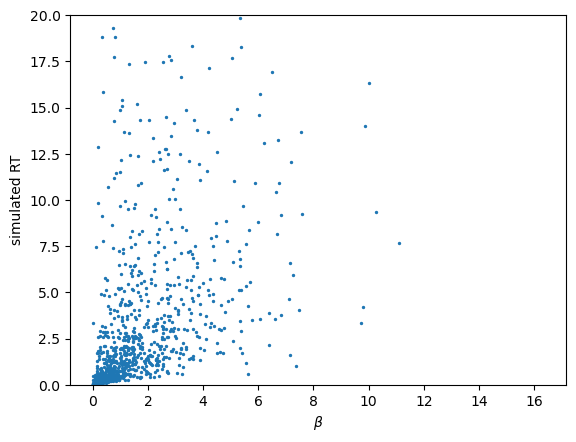

In [9]:
plt.figure();
beta = theta[:,0] # first column in the parameter dataset
RT = x[:,0] # first column in the simulated dataset
plt.scatter(beta[:1000],RT[:1000], s=2); # we plot just the first 1000 datapoints
plt.ylim([0, 20]);
plt.xlabel(r'$\beta$');
plt.ylabel('simulated RT');

### Train MNLE
Now we use the training data to train an neural network to approximate the conditional likelihood of data $x$ given parameters $\theta$, i.e. $p(x|\theta)$ - in our case, data = (choices,RT), parameters = ($\beta$, $\rho$).

In [10]:
# Train MNLE and obtain MCMC-based posterior.
trainer = MNLE() # create MNLE object

# add simulations (input = parameters, output = behavior)
trainer = trainer.append_simulations(theta, x)

# train the neural network: the estimator object now approximates the likelihood (conditioned on parameters)
estimator = trainer.train(training_batch_size=1000)

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\sbi\neural_nets\mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 86 epochs.

### Testing MNLE

We can test compare the likelihood provided by MNLE at a given set of parameters to the distributions obtained by simulating repeatedly the model at these same set of parameters. We can obtain the likelihoods of the reaction time and choices, given the underlying parameter, by calling `.log_prob()`.

In [11]:
# Let's first simulate more trials from the model
M = 1000
x_model = mixed_simulator(theta_o.repeat(M, 1))
# To be able to plot the data in 1D we again encode choices as sign.
x_model_1d = x_model[:, :1]
# Set reaction times negative for zero-choices.
x_model_1d[x_model[:, 1:] == 0,] *= -1

Now compute the likelihoods of reaction times and choices.

In [12]:
# Construct test reaction times.
test_data = torch.linspace(-20, 20, 1000)
# Separate rts and choices.
test_rts = abs(test_data)
test_cs = torch.ones_like(test_data)
test_cs[test_data < 0] = 0
test_x = torch.stack((test_rts, test_cs), dim=1)

# Get the log likelihood of the entire range of reaction times and choices.
mnle_likelihoods = estimator.log_prob(test_x, theta_o.repeat(1000, 1)).detach()

And compare the model data, the synthetic data from MNLE and the likelihood.

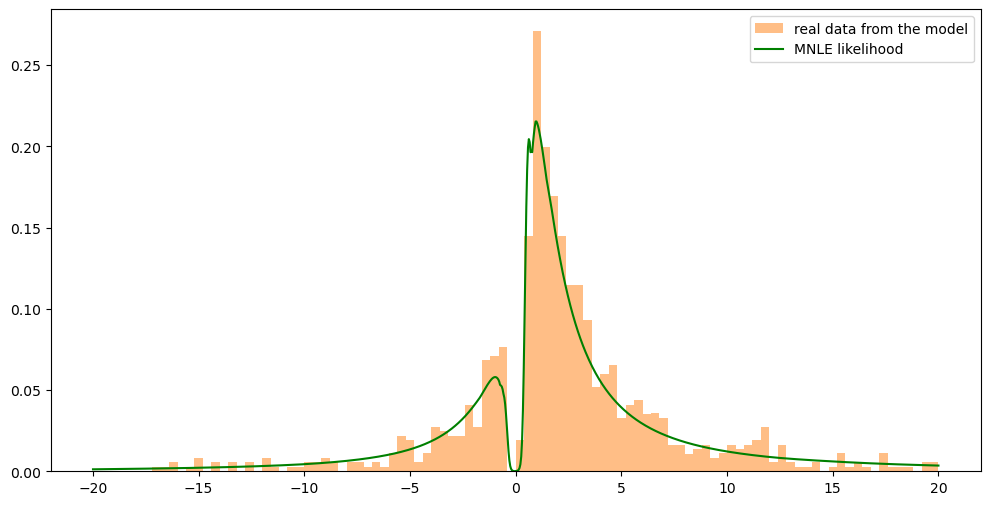

In [13]:
# Plot the real simulated data,  and the learned synthetic likelihoods.
plt.figure(figsize=(12, 6))
density = True

# Plot real data on top,
plt.hist(
    x_model_1d.numpy(),
    bins=np.linspace(-20, 20, 101),
    alpha=0.5,
    color="C1",
    label="real data from the model",
    density=density,
)
# and the MNLE likelihoods
plt.plot(
    test_data, mnle_likelihoods.exp(), label="MNLE likelihood", ls="-", c="green"
)
plt.legend();

### Estimate the posterior over parameters for our experimental dataset
Finally we can pass our experimental dataset using and compute the approximate posterior.

In [14]:
# Build posterior object from the trained estimator of the likelihood and prior.
mnle_posterior = trainer.build_posterior(prior=prior)

# Using the trainer object we can obtain the posterior object with the 
# desired MCMC options for inference.

# MCMC options
mcmc_kwargs = dict(
    num_chains=20, # number of chains
    warmup_steps=50, # number of warmup chains
    method="slice_np_vectorized", # type of MCMC algorithm
    init_strategy="proposal",
)

num_samples = 1000 # number of samples from the posterior (the more we take, the more precise our approximate posterior will be, but this will take longer)
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\sbi\utils\sbiutils.py:342: UserWarning: An x with a batch size of 10 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

The output is simply a tensor with one sample from the posterior on each row (the first column represents the $\beta$ parameter, the second olumn represents $\rho$)

In [15]:
mnle_samples

tensor([[1.2075, 0.8288],
        [1.9067, 0.5733],
        [1.5283, 0.4152],
        ...,
        [2.4520, 0.6751],
        [1.7871, 0.7329],
        [2.0388, 0.7355]])

Let us plot the posterior over these parameters using `pairplot`. In `pairplot`, the panels along the diagonal represent the posterior over a single variable (so here, top-left represent posterior over $\beta$, bottom-right represents the posterior over $\rho$), while other panels represent the posteriors over the a pair of variable using contour plots. We added the true values of the parameters as lines and asterisk, and the prior in blue. You can see that how posterior does a pretty good job, and this with just 10 trials!

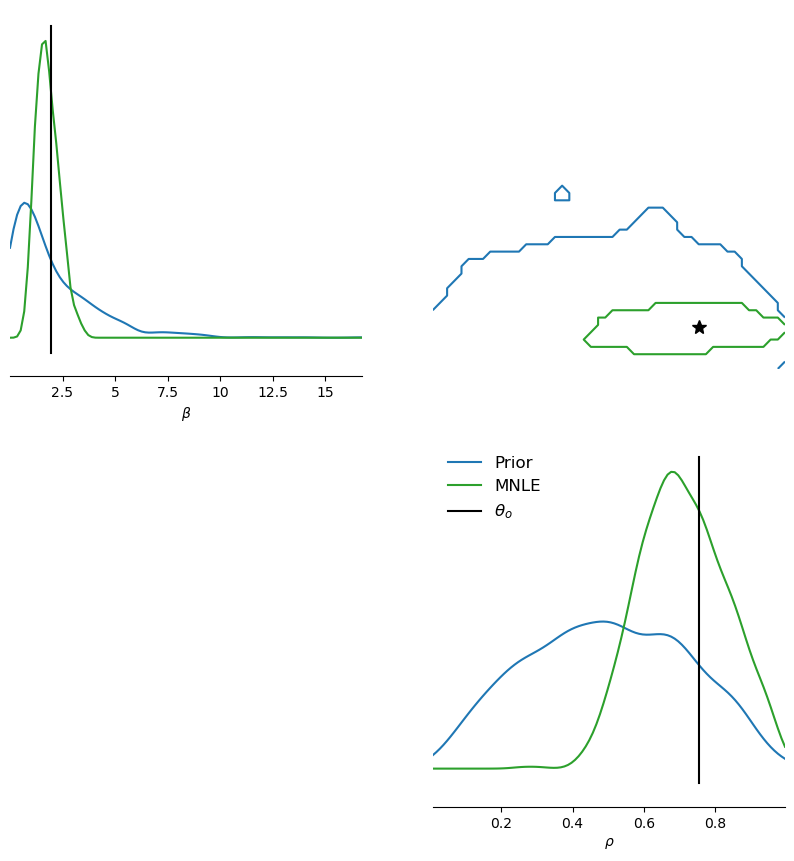

In [16]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    [
        prior.sample((1000,)), # plot prior distribution over parameters
        mnle_samples, # and posterior distribution over parameters obtained with MLNE with MCMC
    ],
    points=theta_o, # true value of the parameters used in the experimental dataset
    diag="kde",
    offdiag="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

### Compare to the posterior obtained from the true likelihood
In this case because the generative model is relatively simple (the `InverseGamma` and the `Binomial` have analytical likelihoods) we do have access to the true likelihood, so we can use this to compare the posterior obtained with either the true likelihood or simulation-based inference.
Of course in real cases we would not use sbi if we would not sbi if we would have access to the true likelihood, but this allows to see how well the method works. We first define this true likelihood below.

In [17]:
# The potential function defines the ground truth likelihood and allows us to
# obtain reference posterior samples via MCMC.
class PotentialFunctionProvider(BasePotential):
    allow_iid_x = True  # type: ignore

    def __init__(self, prior, x_o, concentration_scaling=1.0, device="cpu"):
        super().__init__(prior, x_o, device)
        self.concentration_scaling = concentration_scaling

    def __call__(self, theta, track_gradients: bool = True):
        theta = atleast_2d(theta)

        with torch.set_grad_enabled(track_gradients):
            iid_ll = self.iid_likelihood(theta)

        return iid_ll + self.prior.log_prob(theta)

    def iid_likelihood(self, theta):
        lp_choices = torch.stack(
            [
                Binomial(probs=th.reshape(1, -1)).log_prob(self.x_o[:, 1:])
                for th in theta[:, 1:]
            ],
            dim=1,
        )

        lp_rts = torch.stack(
            [
                InverseGamma(
                    concentration=self.concentration_scaling * torch.ones_like(beta_i),
                    rate=beta_i,
                ).log_prob(self.x_o[:, :1])
                for beta_i in theta[:, :1]
            ],
            dim=1,
        )

        joint_likelihood = (lp_choices + lp_rts).squeeze()

        assert joint_likelihood.shape == torch.Size([self.x_o.shape[0], theta.shape[0]])
        return joint_likelihood.sum(0)

Now let's use MCMC to approximate the posterior over the parameters (with the same dataset as previously) using the true likelihood.

In [18]:
true_posterior = MCMCPosterior(
    potential_fn=PotentialFunctionProvider(prior, x_o), # true likelihood applied to our dataset
    proposal=prior,
    theta_transform=mcmc_transform(prior, enable_transform=True),
    **mcmc_kwargs,
)
true_samples = true_posterior.sample((num_samples,))

Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

### Compare MNLE and reference posterior


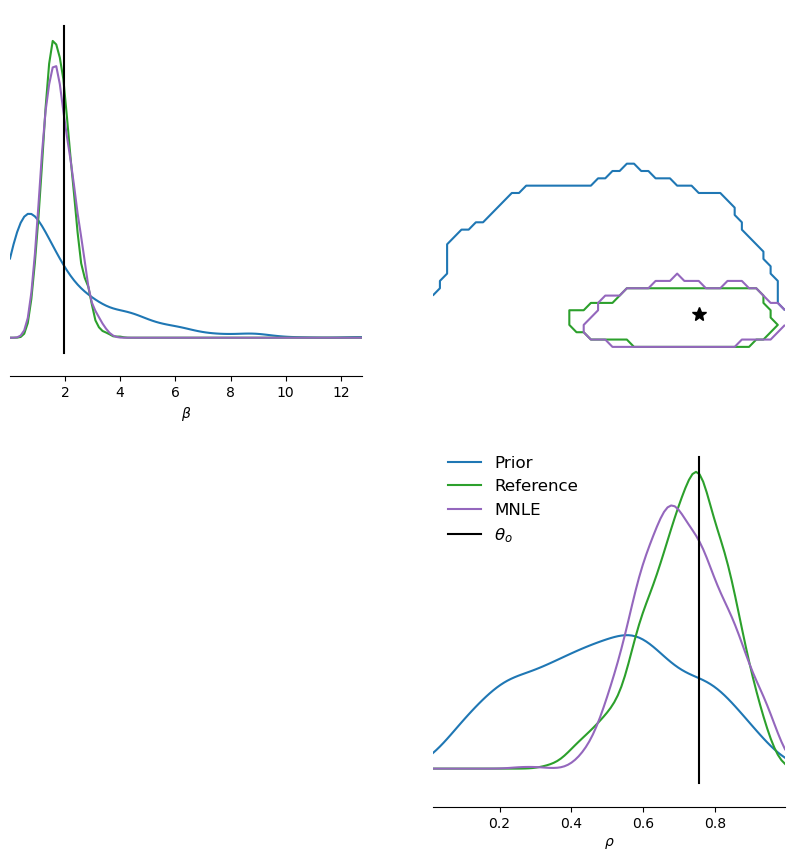

In [19]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_samples,
        mnle_samples,
    ],
    points=theta_o,
    diag="kde",
    offdiag="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

We see that the inferred `MNLE` posterior nicely matches the reference posterior, and how both inferred a posterior that is quite different from the prior.

### Repeat inference with more trials in the experimental dataset
Because MNLE training is amortized we can obtain another posterior given a different observation with potentially a different number of trials, just by running MCMC again (without re-training `MNLE`):

In [20]:
# generate new 'experimental dataset'
num_trials = 50
x_o = mixed_simulator(theta_o.repeat(num_trials, 1))
true_samples = true_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o, **mcmc_kwargs)

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\sbi\utils\sbiutils.py:342: UserWarning: An x with a batch size of 50 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

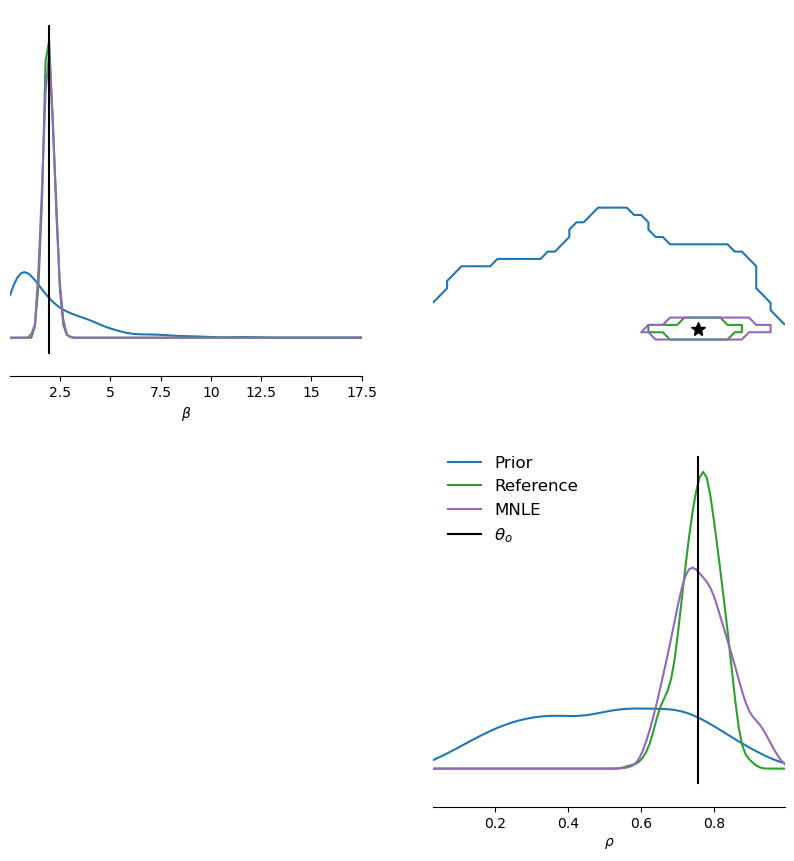

In [21]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot(
    [
        prior.sample((1000,)),
        true_samples,
        mnle_samples,
    ],
    points=theta_o,
    diag="kde",
    offdiag="contour",
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    points_colors=["k"],
    points_offdiag=dict(marker="*", markersize=10),
    labels=[r"$\beta$", r"$\rho$"],
)

plt.sca(ax[1, 1])
plt.legend(
    ["Prior", "Reference", "MNLE", r"$\theta_o$"],
    frameon=False,
    fontsize=12,
);

In [22]:
# Calculate c2st score between reference posterior and approximate posterior samples.
print(c2st(true_samples, mnle_samples)[0])

tensor(0.5360)


Again we can see that the posteriors match nicely. In addition, we observe that the posterior's (epistemic) uncertainty reduces as we increase the number of trials.

Note: `MNLE` is trained on single-trial data. Theoretically, density estimation is perfectly accurate only in the limit of infinite training data. Thus, training with a finite amount of training data naturally induces a small bias in the density estimator.
As we observed above, this bias is so small that we don't really notice it, e.g., the `c2st` scores were close to 0.5.
However, when we increase the number of trials in `x_o` dramatically (on the order of 1000s) the small bias can accumulate over the trials and inference with `MNLE` can become less accurate.


# MNLE with experimental conditions

Decision-making experiments usually vary experimental conditions, and we want to include these experimental conditions (e.g. stimulus properties, context, etc.) as input variables to our model.
In MNLE, we are learning an emulator that should be able to generate synthetic experimental data including reaction times and choices given different experimental conditions.
Thus, to make MNLE work with experimental conditions, we need to include them in the training process, i.e., treat them like auxiliary parameters of the simulator.
We now write a simulating function that takes two tensors as input: a tensor for the parameters and a tensor for the experimental conditions.
The model still produces reaction times and choices, but now depending on some stimulus evidence $s$ (a value between 0 and 6):
- reaction times are sampled from `inverse Gamma`: $rt \sim \text{InverseGamma}(\alpha, \beta*(1+s))$. This captures the fact that in general reaction times will be faster if the stimulus is stronger.
- choices are taken to be 1 with probability $\sigma(\rho*s)$, where $\sigma$ is the logistic function (sigmoidal) and $\rho$ represents the sensitivity of choices to the stimulus.
(Note: this is actually a very bad model for reaction times and choices!)

This model still has two free parameters $(\beta,\rho)$ and still outputs two variables, but the output also depends on experimental conditions (stimulus $s$).

In [23]:
# Toy simulator for mixed data
def simulate_mixed_model(theta: Tensor, conditions: Tensor, concentration_scaling=2):
    """Returns a sample from a mixed distribution given parameters and experimental conditionstheta.
    
    Args:
        theta: batch of parameters, shape (batch_size, 2)
        First column: beta parameter
        Second column: lambda parameter
        conditions: batch of experimental conditions, shape (batch_size, 1)
        First column: stimulus evidence
    """
    # first column is beta parameter, second is rho
    beta, rho = theta[:, :1], theta[:, 1:]

    # first column in conditions is stim
    stim = conditions[:,:1]
    
    # simulate choices using binomial distribution
    pRight = torch.sigmoid(rho*stim)
    choices = Binomial(probs=pRight).sample()

    # simulate gamma using inverse gamma distribution
    alpha = concentration_scaling * torch.ones_like(beta)
    rts = InverseGamma(concentration=alpha, rate=beta*(1+torch.abs(stim))).sample()

    # concatenate RTS and choices in tensor
    x = torch.cat((rts, choices), dim=1)
    return x

### Generating training dataset
Now to generate our training dataset we need to generate values not only for the model parameters but also for the experimental conditions, using a proposal distribution. This prior should reflect the values used in the experimental data. Here we will use three different levels of stimulus, sampled from a uniform distribution.
Then we can generate our training dataset exactly as before.

In [24]:
# Define a proposal that contains both, priors for the parameters and a discrte
# prior over experimental conditions.
#StimValues = torch.tensor(range(-3,4))
proposal = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])), # prior for beta parameter
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])), # prior for rho parameter
        Uniform(torch.tensor([-3.0]),torch.tensor([3.0])), # uniform prior for stimulus
    ],
    validate_args=False,
)

# Generate samples for parameters and experimental conditions
n_params = 2 # number of parameters in model
num_simulations =  10000
theta_conditions = proposal.sample((num_simulations,)) # generate parameters and condiions for each trial
theta = theta_conditions[:,:n_params] # first columns are parameters
conditions = theta_conditions[:,n_params:] # last columns are experimental conditions

# simulate the model (each trial with the corresponding set of parameters and experimental conditions)
x = simulate_mixed_model(theta,conditions)
assert x.shape == (num_simulations, 2)

### Defining the prior over parameters
As in the previous example we define the prior, i.e., the distribution over the parameters we want to infer. Here we do not include any distribution over experimental conditions (unlike the proposal distribution used to generate the training dataset), since these conditions are provided in the experimental dataset.

In [25]:
prior = MultipleIndependent(
    [
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])),
        Gamma(torch.tensor([1.0]), torch.tensor([0.5])), # prior for rho parameter
    ],
    validate_args=False,
)
prior_transform = mcmc_transform(prior)

### Train MNLE including experimental conditions
This step is identical to the previous example

In [26]:
# initialize MNLE object with proposal distribution
trainer = MNLE(proposal)

# add simulations (input = parameters+experimental conditions, output = behavior)
trainer = trainer.append_simulations(theta_conditions, x)

# train neural network
estimator = trainer.train(training_batch_size=100)

C:\Users\Alex\AppData\Roaming\Python\Python39\site-packages\sbi\neural_nets\mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 78 epochs.

### Load our experimental dataset

In [59]:
# simulate observed data and define ground truth parameters
num_trials = 200
theta_cond_o = proposal.sample((num_trials,)) # generate experimental conditions and parameters
theta_o = theta_cond_o[0,:2] #fixed parameters
beta_true = theta_o[0]
rho_true = theta_o[1]
conditions = theta_cond_o[:,2:]
print("True value of beta in experimental dataset",beta_true.numpy())
print("True value of rho in experimental dataset",rho_true.numpy())

# simulate data 
x_o = simulate_mixed_model(theta_o.repeat(num_trials, 1), conditions)

# convert it to dataframe so it really looks like a real dataset
data = torch.column_stack((conditions, x_o)) # this is our experimental dataset with conditions and behavior
df = pd.DataFrame(data.numpy(), columns=['Stimulus', 'RT','choice'])
df.head()

True value of beta in experimental dataset 4.1478353
True value of rho in experimental dataset 3.8356647


,Stimulus,RT,choice
0,1.025710,4.523725,1.0
1,-1.902135,2.785133,0.0
2,0.096467,1.861283,0.0
3,-0.607230,3.993986,1.0
4,-1.076588,30.779266,0.0


### Find maximum-likelihood estimates
Here we will not use a Bayesian approach with MCMC but simply find the maximum likelihood estimates for our experimental dataset, using the approximate likelihood function provided by MNLE (instead of the true likelihood which we do not have access to).

In [28]:
def ModelNegLogLikelihood(theta, data, estimator, nConditions=1):
    n_trials = data.shape[0] # number of observations

    conditions = data[:,:nConditions] # first columns represent experimental conditions
    x = data[:,nConditions:] # last columns represent output behavior
    
    # convert theta to 2D tensor
    theta = torch.reshape(torch.tensor(theta),
                          (1, len(theta))).to(torch.float32)
    theta = theta.repeat(n_trials, 1)

    # add columns for conditions
    theta = torch.column_stack((theta, conditions))
   
    # compute log-likelihood for each trial
    log_liks = estimator.log_prob(x, context=theta).detach().numpy()

    # negative log-likelihood
    negLLH = -np.nansum(log_liks)  # -LLH (data | theta)
   
    return negLLH

In [60]:
# THIS PART YOU SHOULD ADAPT TO YOUR OWN MODEL 

#select relevant variables from your dataframe
# IMPORTANT: place experimental conditions first, behavioral measures last
df_sub = df[['Stimulus','RT','choice']]
nConditions = 1 # here only one experimental condition: stimulus

# convert to pytorch tensor
# (we already had it but this is just to show how this would work with a real example)
data_torch = torch.tensor(df_sub.to_numpy())

# Define the bounds for each variable
bounds = [(0.01, 10), (0.01, 10)]  # Example bounds: both variables are between 0 and 1

# Initial guess for parameter set
x0 = [0.6, 0.8]

# Perform the optimization with bounds
result = optimize.minimize(ModelNegLogLikelihood, x0=x0, args=(data_torch,estimator, nConditions), bounds=bounds, method='Nelder-Mead')

# Retrieve the optimized parameters
(beta_hat, rho_hat) = result.x

# print
print("beta_hat =",beta_hat)
print("rho_hat =",rho_hat)

beta_hat = 3.447873689356726
rho_hat = 3.1144048115261276


We see that the MLE parameters are actually a good estimate of the true parameters underlying the experimental dataset. The method works!